In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [2]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=300,
                  cluster_std=[0.5, 0.5, 0.5],
                  random_state=random_state)

X = X[y==0,:]
y = y[y==0]
# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [3]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

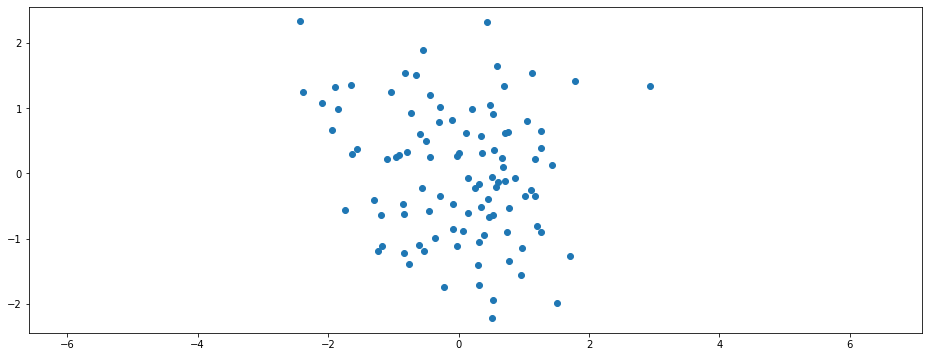

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Variance Matching bug Here

Check out ln_prior there I am tweaking $\sigma_w$ Ive set the log_lieklihood to be 1 this way our algorithm should be trying to have as target the prior . For some reason the neural net is completely unable to match the variance I am specifying I have gone from very low to very high and the method is unable to do anhything to fit the target variance. For a sufficiently small $\Delta t$ we should be able to do this, standard VI is able to do this, so theres some sort of bug / issue here. 

In [49]:
def log_gaussian(x, mean=0):
    """
    Returns the density of x under the supplied gaussian. Defaults to
    standard gaussian N(0, I)
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :return: (*) elementwise log density
    """
    
    log_norm_constant = -0.5 * np.log(2 * np.pi)
    
    var =  torch.tensor(0.1)
    logvar = torch.log(var).reshape(1,1).to(device)
    
    A = (x - mean) ** 2
    log_p = -0.5 * (logvar + A / logvar.exp())
    log_p = log_p + log_norm_constant
    return log_p.sum(dim=-1)


# TODO: Why is changing σ_w doing nothing ??
def ln_prior(Θ, σ_w=20.1):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


def log_likelihood_single(μ, X, log=True):
    """
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?

    """
    
    n, d = X.shape
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], 
        μ.reshape(1, d)[:, None, :], 
    )

    return log_likelihoods.sum() * 0 


def log_likelihood(Θ, X, y=None):
    """
    batching the above (hopefully its right)
    """

    loss_ = lambda μ: log_likelihood_single(μ, X)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(Θ)

In [50]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim =  2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [51]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              ln_prior, log_likelihood, γ=1.0, device=device)

C:\Users\vargf\anaconda3\lib\site-packages\torch\_vmap_internals.py:252: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk.
  warnings.warn(
<ipython-input-49-8f985ae4f38f>:47: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum() * 0


tensor(-0.7941, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
γ = 1.0
Δt=0.005
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.001, weight_decay =0.1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300

train = True
if train:
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = relative_entropy_control_cost(
                    sde, Θ_0.float(),
                    X_train.float(), y_train.float(),
                    ln_prior, log_likelihood, γ=γ
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = relative_entropy_control_cost(
                sde, Θ_0,
                X_train, y_train,
                ln_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

200


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\vargf\anaconda3\lib\site-packages\torch\_vmap_internals.py:252: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk.
  warnings.warn(
<ipython-input-49-8f985ae4f38f>:47: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum() * 0


In [64]:
losses

[-0.4647796154022217,
 -0.537301242351532,
 -0.3856673240661621,
 -0.6698821187019348,
 -0.6539483666419983,
 -0.4159020185470581,
 -0.4942839741706848,
 -0.689004123210907,
 -0.8365722298622131,
 -0.6079326868057251,
 -0.53941810131073,
 -0.6601086258888245,
 -0.7896173596382141,
 -0.6144360303878784,
 -0.7306068539619446,
 -0.6902567148208618,
 -0.6193599104881287,
 -0.6633678078651428,
 -0.6855069398880005,
 -0.5365524888038635,
 -0.7705076336860657,
 -0.9473477005958557,
 -0.7276336550712585,
 -0.872390866279602,
 -0.7205917835235596,
 -0.7011956572532654,
 -0.5857495665550232,
 -0.593991756439209,
 -0.6528027057647705,
 -0.9823471903800964,
 -0.9088006615638733,
 -0.7403904795646667,
 -0.9428442120552063,
 -1.052393913269043,
 -0.8318302631378174,
 -0.8535749912261963,
 -0.785476803779602,
 -1.1613577604293823,
 -0.7905437350273132,
 -0.9735972881317139,
 -1.0275615453720093,
 -1.1115891933441162,
 -0.8174905776977539,
 -0.8747046589851379,
 -0.9245712161064148,
 -0.84754234552383

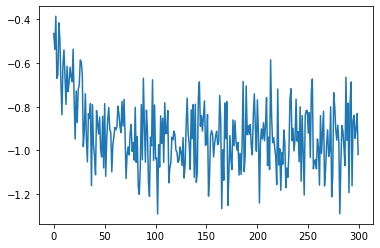

In [65]:
plt.plot(losses[:])

In [66]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([200, 50, 2])

In [67]:
torch.eye(3,2)

tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

In [68]:
# Mannualy doing one step of Euler

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [69]:
Θ_1 = Θ_1.reshape(50,2)

(array([ 1.,  3.,  3.,  6., 11.,  6.,  7.,  6.,  3.,  4.]),
 array([-2.0759783 , -1.6389178 , -1.2018573 , -0.7647968 , -0.3277363 ,
         0.10932422,  0.5463847 ,  0.9834452 ,  1.4205058 ,  1.8575662 ,
         2.2946267 ], dtype=float32),
 <a list of 10 Patch objects>)

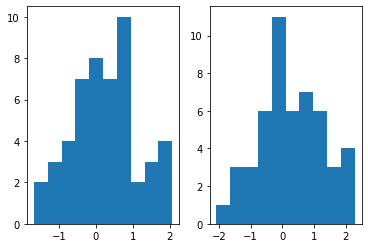

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,1].flatten().cpu().detach().numpy())

In [71]:

# Manually doing 2 steps of euler 
Θ_2 = sde.f(0, 
        sde.f(0, Θ_0) * Δt + torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)
    ) * Δt +  torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)

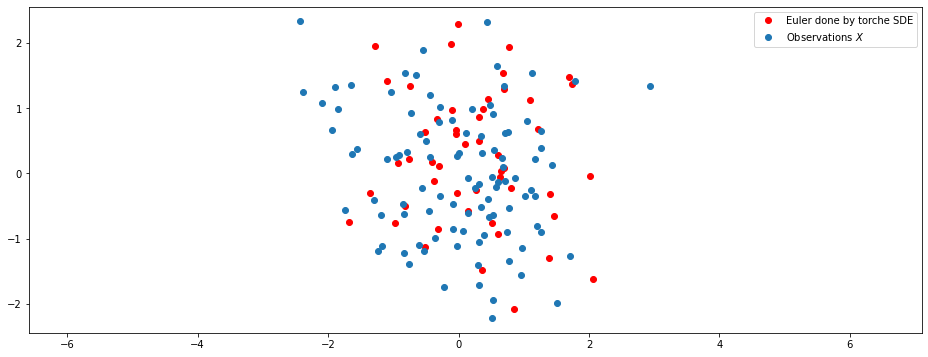

In [72]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)

Θ_plot2 = Θ_2.cpu().detach() 



ax_1.plot(Θ_plot[:, 0], Θ_plot[:, 1], 
         linestyle='none', 
         marker='o', color="red", label="Euler done by torche SDE")

# ax_1.plot(Θ_plot2[:, 0], Θ_plot2[:, 1], 
#          linestyle='none', 
#          marker='o', color="blue", label="Euler done manually")

ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');